In [2]:
import cloudscraper
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import re
import requests
from dotenv import load_dotenv
import os

# Dummy dataset 
### For company reporting, this dataset is collected by company

In [ ]:
'''
------------------------------------------------------------------------------------------------------------------------
create dummy dataset of employee locations around Johor Bahru while their workplace is Hospital Sultanah Aminah (HSA)
-------------------------------------------------------------------------------------------------------------------------

# Create a CloudScraper object
scraper = cloudscraper.create_scraper()

# Using URL of PropertyGuru rental property search to create dummy data for employee location around Johor Bahru
search_url_1 = "https://www.propertyguru.com.my/property-for-rent/"
search_url_2 = "?district_code=JH016&freetext=Johor+Bahru,+Johor&listing_type=rent&market=residential&district_code=JH016&region_code=MY01&search=true"
# Create list to store property information
location_list = []

# Create counter for the number of scraped properties
n_scraped = 0

# Loop through the search results pages
for page in range(1, 10):  # range(1, n_pages + 1):
    # Make a search request
    response = scraper.get(search_url_1 + f"/{page}"+search_url_2)

    # Parse the search results
    soup = BeautifulSoup(response.content, "lxml")

    # Detect captcha
    if "captcha" in soup.text:
        print("Captcha detected when trying to scrape " + search_url + f"/{page}")

    # Get list of property cards that contain property information (identified by div tags with a specific class)
    property_card_list = soup.find_all("div", {"class": "listing-card"})

    # Loop through the property cards
    for property_card in property_card_list:
        # Get property name (identified by an HTML anchor tag with a specific class and item property)
        name = property_card.find("a", {"class": "nav-link", "itemprop": "url"}).get_text()

        # Get property address (identified by an HTML span tag with a specific item property)
        address = property_card.find("span", {"itemprop": "streetAddress"}).get_text()

        # Add property to the property list
        location_list.append([name, address])
        
    # Update the number of scraped properties
    n_scraped += len(property_card_list)
    # Show number of scraped properties
    print(f"Number of scraped properties: {n_scraped}")

# Show first 10 elements of the list of employee locations
print(location_list[:10])

# Show total number of employee locations
print(len(location_list))

# Convert list of employee locations to pandas dataframe
new_data = pd.DataFrame(location_list, columns=["name", "address"])
new_data.index = new_data.index+1

# create new csv file with new_data
new_data.to_csv("data/preprocessing/employee_commute_emissions1.csv",index=True)


    
'''

In [ ]:
# Read the existing csv
df = pd.read_csv("data/preprocessing/employee_commute_emissions1.csv")

In [ ]:
df["employee_ID"] = 'EmpID00' + df.index.astype(str)

In [ ]:
fractions = [0.1, 0.42, 0.15, 0.13, 0.17,0.01,0.02]
total = 180

integers = [int(fraction * total) for fraction in fractions]

# Ensure the sum of the integers is 399
if sum(integers) != total:
    diff = total - sum(integers)
    # Distribute the difference among the integers
    integers[0] += diff

print(integers)

In [ ]:
import random
# create random vehicle list
vehicle_list = ['Small_car' for _ in range(integers[0])]+['Medium_car' for _ in range(integers[1])]+['Large_car' for _ in range(integers[2])]+['Average_car' for _ in range(integers[3])]+['Medium_motorbike' for _ in range(integers[4])]+['Large_motorbike' for _ in range(integers[5])]+ ['Average_local_bus' for _ in range(integers[6])]
# shuffle vehicle list
random.shuffle(vehicle_list)

In [ ]:
# add the transportation column to the dataset (again, company should collect their own data)
df["transportation_to_work"] = vehicle_list

# Using Google Maps API to calculate distance to workplace of all addresses

In [ ]:
# Load environment variables from .env file
load_dotenv()

In [ ]:
# Get Google Maps API key from .env 
google_maps_api_key = os.getenv("google_maps_api_key")

In [ ]:
# Create function to get latitude and longitude from an address 
def get_latitude_longitude(address):
    # Base URL for the Google Maps Geocoding API
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    
    # Parameters for the Geocoding API request
    params = {
        "address": f"{address}, Malaysia",
        "key": google_maps_api_key
    }
    
    # Send Geocoding API request and store the response
    response = requests.get(base_url, params=params)
    data = response.json()
    
    # Check if request was successful
    if data["status"] == "OK":
        # Extract latitude and longitude from the response
        location = data["results"][0]["geometry"]["location"]
        latitude = location["lat"]
        longitude = location["lng"]
    else:
        # Assign missing values and print error message if the request failed
        latitude = np.nan
        longitude = np.nan
        print(f"Geocoding request failed for {address}")
    
    # Return latitude and longitude
    return (latitude, longitude)

In [ ]:
# Apply function to create latitude and longitude column 
# Cost: 8.41$. More precisely, 0.005$ per API call for 1682 addresses.
# df[["latitude", "longitude"]] = df["address"].apply(get_latitude_longitude).apply(pd.Series)

In [ ]:
df[["latitude", "longitude"]] = df["address"].apply(get_latitude_longitude).apply(pd.Series)

In [ ]:
# Create function to get meters to work place (Hospital Sultanah Aminah) 
def get_meters_to_hsa(row):
    # Get latitude and longitude of the property
    emploc_latitude = row["latitude"]
    emploc_longitude = row["longitude"]
    
    # Return a missing value if latitude or longitude is missing
    if np.isnan(emploc_latitude) or np.isnan(emploc_longitude):
        print(f"Employee location latitude or longitude missing for {row['address']}")
        return np.nan
    
    # Latitude and longitude of work place location (ie. Hospital Sultanah Aminah  )
    HSA_latitude = 1.458699
    HSA_longitude = 103.746044

    # Base URL for the Google Maps Distance Matrix API
    base_url = "https://maps.googleapis.com/maps/api/distancematrix/json"
    
    # Parameters for the Distance Matrix API request
    params = {
        "origins": f"{emploc_latitude},{emploc_longitude}",
        "destinations": f"{HSA_latitude},{HSA_longitude}",
        "key": google_maps_api_key
    }

    # Send the Distance Matrix API request and store the response
    response = requests.get(base_url, params=params)
    data = response.json()

    # Process the response to get the distance
    if "rows" in data and data["rows"]:
        meters_to_hsa = data["rows"][0]["elements"][0]["distance"]["value"]
        #print(f"Distance between employee location and HSA: {meters_to_hsa} meters")
    else:
        print("No distance information available.")
        return np.nan
    return meters_to_hsa

In [ ]:
# Apply function to create the "meters_to_workplace" column 
# Cost: 8.4$. More precisely, 0.005$ per distance for 1680 distances.
df["meters_to_workplace"] =  df.apply(get_meters_to_hsa, axis=1)

In [ ]:
# There are a total of 260 working days in the 2023 calendar year
# the total distance travelled by vehicle (km) is calculated as: ∑ (daily one way distance between home and work (km) × 2 × 5 × number of commuting weeks per year)
#∑ (total distance travelled by vehicle type (vehicle-km or passenger-km) × vehicle specific emission factor (kg CO2e/vehicle-km or kg CO2e/passenger-km))

In [ ]:
df.to_csv("data/preprocessing/employee_commute_emissions_2.csv", index=True, header= True)

In [ ]:
df = pd.read_csv("data/preprocessing/employee_commute_emissions_2.csv")

In [ ]:
# GHG protocol Chapter 7: Calculating emissions from employee travel using the distance-based method
# There are a total of 260 working days in the 2023 calendar year
# the total distance travelled by vehicle (km) is calculated as: ∑ (daily one way distance between home and work (km) × 2  × number of commuting days per year)
# ∑ (total distance travelled by vehicle type (vehicle-km or passenger-km) × vehicle specific emission factor (kg CO2e/vehicle-km or kg CO2e/passenger-km))
# first, sum across all employees to determine total distance travelled using each vehicle type,then, sum across vehicle types to determine total emissions

In [ ]:
# CO2 Emissions according to UK goverment emmission factor
#https://www.gov.uk/government/publications/greenhouse-gas-reporting-conversion-factors-2022
# All emission factor are based on petrol vehicle in kg CO2 emission per unit
dict_co2e = dict(zip(['Small_car' ,'Medium_car', 'Large_car', 'Average_car','Small_motorbike' ,'Medium_motorbike', 'Large_motorbike', 'Average_motorbike','Average_local_bus'], [.14652, .18470, .27639, .17048, .08306, .10090, .13245, .11355, 0.0965]))

In [ ]:
# Calculation @ line level
# CO2 Total is total kilograms of CO2 emission per employee
df_line = df.copy()

dict_co2e = dict(zip(['Small_car' ,'Medium_car', 'Large_car', 'Average_car','Small_motorbike' ,'Medium_motorbike', 'Large_motorbike', 'Average_motorbike','Average_local_bus'], [.14652, .18470, .27639, .17048, .08306, .10090, .13245, .11355, 0.0965]))
MODES = ['Small_car' ,'Medium_car', 'Large_car', 'Average_car','Small_motorbike' ,'Medium_motorbike', 'Large_motorbike', 'Average_motorbike','Average_local_bus']
for i in range(1,181):
    for mode in MODES:
        if df_line.loc[i,'transportation_to_work']== mode:
            df_line.loc[i,'CO2_Total' ] = df_line.loc[i,'meters_to_workplace'].astype(float)/1000 *2 *260 *dict_co2e[mode]

df_line.head()

In [ ]:
df_line.to_csv("data/preprocessing/employee_commute_emissions_final.csv", index=False)

In [ ]:
# Company's annual kilograms of CO2 emission of all employee commuting
df_line["CO2_Total"].sum()

In [ ]:
# Hospital Sultanah Aminah employee's average carbon dioxide emissions per capita (in kilograms of carbon dioxide per capita)
df_line["CO2_Total"].mean()

# Visualize employee locations on the map

In [167]:
import folium
df= pd.read_csv("data/preprocessing/employee_commute_emissions_final.csv")

In [169]:
# Create a map centered around Hospital Sultanah Aminah
map = folium.Map(location=[1.458699, 103.746044], zoom_start=11) 

# Add property markers to the map
radius = 20
folium.CircleMarker(
    location=[1.458699, 103.746044],
    radius=radius,
    color="red",
    stroke=False,
    fill=True,
    fill_opacity=1,
    opacity=1,
    popup="{} pixels".format(radius),
    tooltip="Hospital Sultanah Aminah",
    ).add_to(map)

# Add property markers to the map
for index, row in df.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        tooltip=row["name"],  # Display property name on hover
    ).add_to(map)

# Show map
map

In [41]:
map.save("data/map.html") 

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

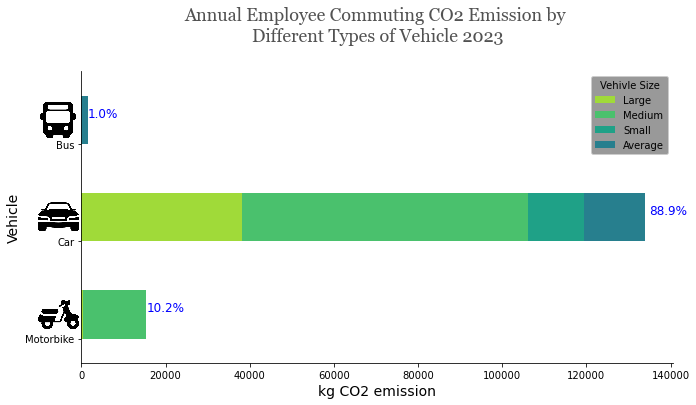

In [180]:
font_color = '#525252'
csfont = {'fontname':'Georgia'} 
colors = sns.color_palette("viridis_r")
data=[["Motorbike", 253.180824, 15063.300460, 0, 0],
      ["Car", 38043.281437, 68016.535964, 13462.691299, 14420.985030],
      ["Bus", 0, 0, 0, 1485.378180]    
     ]

# Add list of icons (file paths) corresponding to each tick label
motorbike = plt.imread("images/motorbike.png")
imagebox_motorbike = OffsetImage(motorbike, zoom =0.08)
# xvbox coordinate to insert the motorbike icon
xy =[1,0]
ab_motorbike = AnnotationBbox(imagebox_motorbike,xy,xybox=(-5500.,0),frameon=False, pad=0)

car = plt.imread("images/car.png")
imagebox_car = OffsetImage(car, zoom =0.08)
# xvbox coordinate to insert the car icon
xy =[2,0]
ab_car = AnnotationBbox(imagebox_car,xy,xybox=(-5500.,1),frameon=False, pad=0)

bus = plt.imread("images/bus.png")
imagebox_bus = OffsetImage(bus, zoom =0.07)
# xvbox coordinate to insert the bus icon
xy =[3,0]
ab_bus = AnnotationBbox(imagebox_bus,xy,xybox=(-5500.,2),frameon=False, pad=0)
####################
# built dataframe  #
####################
dataframe =pd.DataFrame(data,columns=["Vehicle","Large", "Medium", "Small", "Average"])
#Calculate the vehicle proportion
df_sum = dataframe.groupby('Vehicle').sum()
sum_row = df_sum.sum(axis=1)
df_percentage = sum_row/sum_row.sum(axis=0)*100
bus_pct= round(df_percentage['Bus'],1)
car_pct= round(df_percentage['Car'],1)
motorbike_pct= round(df_percentage['Motorbike'],1)

###############
# plot graph  #
###############
ax = dataframe.plot.barh(align='center', stacked=True, figsize=(10, 6),color=colors)
ax = plt.gca()

# Hide the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('Vehicle', fontsize =14)
ax.set_xlabel('kg CO2 emission', fontsize =14)
ax.add_artist(ab_motorbike)
ax.add_artist(ab_car)
ax.add_artist(ab_bus)
ax.set_facecolor("white")
ax.legend(title = 'Vehivle Size',facecolor='gray')
plt.yticks([-0.25,0.75,1.75], ['Motorbike', 'Car','Bus'] ) 
plt.annotate(f'{bus_pct}'+'%',xy = (5000,2), horizontalalignment ='center', verticalalignment ='bottom', color='blue', fontsize=12)
plt.annotate(f'{car_pct}'+'%',xy = (139500,1), horizontalalignment ='center', verticalalignment ='bottom', color='blue', fontsize=12)
plt.annotate(f'{motorbike_pct}'+'%',xy = (20000,0), horizontalalignment ='center', verticalalignment ='bottom', color='blue', fontsize=12)
plt.title('Annual Employee Commuting CO2 Emission by \nDifferent Types of Vehicle 2023',pad=30, fontsize=18, color=font_color, **csfont)
plt.tight_layout()

# Set the background color to white
fig = plt.gcf()  # Get the current figure
fig.patch.set_facecolor('white')
plt.savefig('employee_commuting_CO2_e.png', bbox_inches='tight')